In [ ]:
#Notebook for training a GCN network to classify cells without the autoencoder training first.

In [1]:
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import torch
from torch.autograd import Variable
from torch.utils.data import TensorDataset,DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch_geometric.utils import get_laplacian
import pandas as pd
import numpy as np
import math
import networkx as nx
import matplotlib

In [2]:
from sklearn.preprocessing import OneHotEncoder

In [3]:
labels = pd.read_csv('data/Labels.csv')

In [4]:
labels[0:100]

,x
0,CD8+ Cytotoxic T
1,CD8+/CD45RA+ Naive Cytotoxic
2,CD4+/CD45RO+ Memory
3,CD19+ B
4,CD4+/CD25 T Reg
...,...
95,CD8+/CD45RA+ Naive Cytotoxic
96,CD8+/CD45RA+ Naive Cytotoxic
97,CD4+/CD45RA+/CD25- Naive T
98,CD4+/CD45RA+/CD25- Naive T


In [5]:
encoder = OneHotEncoder(handle_unknown='ignore')
labels_df = pd.DataFrame(encoder.fit_transform(labels[['x']]).toarray())

print(labels_df)

        0    1    2    3    4    5    6    7    8    9    10
0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0
1      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0
2      0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
3      0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
4      0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
65938  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0
65939  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0
65940  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0
65941  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0
65942  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0

[65943 rows x 11 columns]


In [6]:
pbmc = np.load('data/pbmc_normalized_filtered2.npy')

In [68]:
#Testing classification using a simple FF network.

class simpleNet(nn.Module):
    def __init__(self,input_dim,device,coef_m=None):
        super(simpleNet, self).__init__()
        self.fc_input=nn.Linear(input_dim,1024)
        self.fc1=nn.Linear(1024,512)
        self.fc2=nn.Linear(512,128)
        self.fc3=nn.Linear(128,10)
        self.dropout=nn.Dropout(0.3)
        self.device=device
    
    def forward(self,x):
        x.to(self.device)
        x=F.relu(self.fc_input(x))
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        outputs=torch.sigmoid(self.fc3(x))
        return outputs

In [69]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

model = simpleNet(input_dim=pbmc.shape[1], device=device)
print(model)

Using cpu device
simpleNet(
  (fc_input): Linear(in_features=2000, out_features=1024, bias=True)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [70]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

x_tensor = torch.tensor(pbmc.astype(np.float32))
y_tensor = torch.tensor(labels_df.values.astype(np.float32))

dataset = TensorDataset(x_tensor, y_tensor)

batch_size = 32
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(x_tensor)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

In [71]:
def train(dataloader, model, loss_fn, optimizer):
    size = math.floor(len(dataloader.dataset)*0.8)
    model.train()
    correct = 0
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error 
        pred = model(X)
        loss = loss_fn(pred, y)
        correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            correct /= 100*batch_size

            print(f"Train accuracy: {(100*correct):>0.1f}%, loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            correct = 0
            
def test(dataloader, model, loss_fn):
    size = math.floor(len(dataloader.dataset)*0.2)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()
    test_loss /= num_batches
    print(correct)
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
epochs = 100
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    test(validation_loader, model, loss_fn)
print("Done!")

In [7]:
#Loading adjacency matrix and filtered gene expression
#The following approach will be based on Graph Convolutional Network methods

adj_mat = np.load('data/adj_mat_on_normalized2.npy')
pbmc = np.load('data/pbmc_normalized_filtered2.npy')

In [164]:
N = adj_mat.shape[0] # number of nodes in a graph
D = np.sum(adj_mat, 0) # node degrees
D_hat_pos = np.diag((D + 1e-5)**(0.5)) # normalized node degrees
D_hat_neg = np.diag((D + 1e-5)**(-0.5)) # normalized node degrees
L = np.identity(N) + D_hat_neg.dot(adj_mat).dot(D_hat_pos) # Laplacian

In [166]:
# Spectral convolution on graphs
# X is an N×1 matrix of 1-dimensional node features
# L is an N×N graph Laplacian computed above
# W_spectral are N×F weights (filters) that we want to train
from scipy.sparse.linalg import eigsh # assumes L to be symmetric

Λ,V = eigsh(L,k=20,which='SM') # eigen-decomposition (i.e. find Λ,V)


In [167]:
#Graph convolution model 1

class GraphConvolution(nn.Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """
    
    def __init__(self, input_dim, in_features, out_features, batch_size, bias=False):
        super(GraphConvolution, self).__init__()
        self.input_dim = input_dim
        self.batch_size = batch_size
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(self.in_features, self.out_features), requires_grad=True)
        if bias:
            self.bias = Parameter(torch.FloatTensor(self.input_dim, self.out_features), requires_grad=True)
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()
        

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.weight, gain=nn.init.calculate_gain('relu'))
#         stdv = 1. / math.sqrt(self.weight.size(1))
#         self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            torch.nn.init.xavier_uniform_(self.bias, gain=nn.init.calculate_gain('relu'))

    def forward(self, input, adj):
#         input = torch.permute(input, (0, 2, 1))
        support = torch.matmul(input, self.weight)
        output = torch.matmul(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'
    
class full_net(nn.Module):
    
    def __init__(self, input_dim, nhidden, p, output_dim, adj, batch_size, dropout):
        super(full_net, self).__init__()
        self.batch_size = batch_size
        self.input_dim = input_dim
        self.nhidden = nhidden
        self.output_dim = output_dim
#         self.fc1 = nn.Linear(input_dim, nhidden, bias=False)
        self.dropout = nn.Dropout(dropout)
        self.poolsize = 8
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.adj = Parameter(torch.from_numpy(adj).contiguous().float(), requires_grad=False).to(self.device)
        self.p = p
        self.gcn = GraphConvolution(self.input_dim, 1, self.nhidden, self.batch_size, bias=False)
#         self.gcn2 = GraphConvolution(self.input_dim, self.nhidden, self.nhidden//2, self.batch_size, bias=False)
        self.fc1 = nn.Linear(int(((self.input_dim//self.p)*nhidden)), 128, bias=True)
        self.fc2 = nn.Linear(128, 32, bias=True)
        self.fc3 = nn.Linear(self.input_dim, 128, bias=True)
        self.fc4 = nn.Linear(128, 32, bias=True)
        self.fc5 = nn.Linear(32, self.output_dim, bias=True)
        
        #Make sure gene order in adj is same!
        #how to implement the attention layer?
        #what's the diff between Parameter and Variable
        
    def graph_max_pool(self, x, p):
        if p > 1:
            x = x.permute(0,2,1).contiguous()  # x = B x F x V
            x = nn.MaxPool1d(p)(x)             # B x F x V/p
            x = x.permute(0,2,1).contiguous()  # x = B x V/p x F
            return x
        else:
            return x
        
    def forward(self, x):
        stream1 = torch.unsqueeze(x, -1)
        stream1 = F.relu(self.gcn(stream1, self.adj))
#         stream1 = F.relu(self.gcn2(stream1, self.adj))
        stream1 = self.graph_max_pool(stream1, self.p)
        stream1 = torch.flatten(stream1, start_dim = 1)
        stream1 = F.relu(self.fc1(stream1))
        stream1 = self.dropout(stream1)
        stream1 = F.relu(self.fc2(stream1))
        
#         stream2 = F.relu(self.fc3(x))
#         stream2 = self.dropout(stream2)
#         stream2 = F.relu(self.fc4(stream2))
        
#         combined = torch.cat((stream1, stream2), -1)
        
        outputs = torch.sigmoid(self.fc5(stream1))
        return outputs

In [168]:
#Graph convolution model with att

class GraphAttConvolution(nn.Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """
    
    def __init__(self, input_dim, in_features, out_features, batch_size, bias=False):
        super(GraphAttConvolution, self).__init__()
        self.input_dim = input_dim
        self.batch_size = batch_size
        self.in_features = in_features
        self.out_features = out_features
        self.att = Parameter(torch.FloatTensor(self.input_dim, self.input_dim), requires_grad=True)
        self.weight = Parameter(torch.FloatTensor(self.in_features, self.out_features), requires_grad=True)
#         self.att = Parameter(torch.FloatTensor(self.input_dim, self.out_features), requires_grad=False)
        if bias:
            self.bias = Parameter(torch.FloatTensor(self.input_dim, self.out_features), requires_grad=True)
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()
        

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.weight, gain=nn.init.calculate_gain('relu'))
        torch.nn.init.xavier_uniform_(self.att, gain=nn.init.calculate_gain('relu'))
#         stdv = 1. / math.sqrt(self.weight.size(1))
#         self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            torch.nn.init.xavier_uniform_(self.bias, gain=nn.init.calculate_gain('relu'))

    def forward(self, input, adj):
#         input = torch.permute(input, (0, 2, 1))
        self.att = Parameter(torch.softmax(self.att, dim=1), requires_grad=True)
        adj = torch.matmul(self.att, adj)
        support = torch.matmul(input, self.weight)
        output = torch.matmul(adj, support)
#         att = torch.softmax(output, dim=1)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'
    
class full_net_att(nn.Module):
    
    def __init__(self, input_dim, nhidden, p, output_dim, adj, batch_size, dropout):
        super(full_net_att, self).__init__()
        self.batch_size = batch_size
        self.input_dim = input_dim
        self.nhidden = nhidden
        self.output_dim = output_dim
#         self.fc1 = nn.Linear(input_dim, nhidden, bias=False)
        self.dropout = nn.Dropout(dropout)
        self.poolsize = 8
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.adj = Parameter(torch.from_numpy(adj).contiguous().float(), requires_grad=False).to(self.device)
        self.p = p
        self.gcn = GraphAttConvolution(self.input_dim, 1, self.nhidden, self.batch_size, bias=False)
#         self.gcn2 = GraphAttConvolution(self.input_dim, self.nhidden, self.nhidden//2, self.batch_size, bias=False)
        self.fc1 = nn.Linear(int(((self.input_dim//self.p)*nhidden)), 128, bias=True)
        self.fc2 = nn.Linear(128, 32, bias=True)
#         self.fc3 = nn.Linear(self.input_dim, 128, bias=True)
#         self.fc4 = nn.Linear(128, 32, bias=True)
        self.fc5 = nn.Linear(32, self.output_dim, bias=True)
        
        #Make sure gene order in adj is same!
        #how to implement the attention layer?
        #what's the diff between Parameter and Variable
        
    def graph_max_pool(self, x, p):
        if p > 1:
            x = x.permute(0,2,1).contiguous()  # x = B x F x V
            x = nn.MaxPool1d(p)(x)             # B x F x V/p
            x = x.permute(0,2,1).contiguous()  # x = B x V/p x F
            return x
        else:
            return x
        
    def forward(self, x):
        stream1 = torch.unsqueeze(x, -1)
        stream1 = F.relu(self.gcn(stream1, self.adj))
#         stream1 = F.relu(self.gcn2(stream1, self.adj))
        stream1 = self.graph_max_pool(stream1, self.p)
        stream1 = torch.flatten(stream1, start_dim = 1)
        stream1 = F.relu(self.fc1(stream1))
        stream1 = self.dropout(stream1)
        stream1 = F.relu(self.fc2(stream1))
        
#         stream2 = F.relu(self.fc3(x))
#         stream2 = self.dropout(stream2)
#         stream2 = F.relu(self.fc4(stream2))
        
#         combined = torch.cat((stream1, stream2), -1)
        
        outputs = torch.sigmoid(self.fc5(stream1))
        return outputs

In [201]:
#Autoencoder using spectral theory model

class SpectralConvolution(nn.Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """
    
    def __init__(self, input_dim, out_features, batch_size, bias=False):
        super(SpectralConvolution, self).__init__()
        self.input_dim = input_dim
        self.batch_size = batch_size
        self.out_features = out_features
        self.weight_spectral = Parameter(torch.FloatTensor(self.input_dim, self.out_features), requires_grad=True)
        if bias:
            self.bias = Parameter(torch.FloatTensor(self.input_dim, self.out_features), requires_grad=True)
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()
        

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.weight_spectral, gain=nn.init.calculate_gain('relu'))
#         stdv = 1. / math.sqrt(self.weight.size(1))
#         self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            torch.nn.init.xavier_uniform_(self.bias, gain=nn.init.calculate_gain('relu'))

    def forward(self, input, V):
        X_hat = torch.matmul(V.T, input) # 20×1 node features in the "spectral" domain
        W_hat = torch.matmul(V.T, self.weight_spectral) # 20×F filters in the "spectral" domain
        output = torch.matmul(V, X_hat * W_hat)  # N×F result of convolution
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.out_features) + ')'
    
class spectral_net(nn.Module):
    
    def __init__(self, input_dim, nhidden, p, output_dim, adj, batch_size, dropout):
        super(spectral_net, self).__init__()
        self.batch_size = batch_size
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.nhidden = nhidden
        self.dropout = nn.Dropout(dropout)
        self.poolsize = 8
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.adj = Parameter(torch.from_numpy(adj).contiguous().float(), requires_grad=False).to(self.device)
        self.p = p
        self.gcn = SpectralConvolution(self.input_dim, self.nhidden, self.batch_size, bias=False)
        self.gcn2 = SpectralConvolution(self.input_dim, self.nhidden, self.batch_size, bias=False)
        self.fc1 = nn.Linear(int(((self.input_dim//self.p)*nhidden)), 128, bias=True)
        self.fc2 = nn.Linear(128, 32, bias=True)
        
        self.fc3 = nn.Linear(self.input_dim, 128, bias=True)
        self.fc4 = nn.Linear(128, 32, bias=True)
        self.fc5 = nn.Linear(64, self.output_dim, bias=True)

        
        #Make sure gene order in adj is same!
        #how to implement the attention layer?
        #what's the diff between Parameter and Variable
        
    def graph_max_pool(self, x, p):
        if p > 1:
            x = x.permute(0,2,1).contiguous()  # x = B x F x V
            x = nn.MaxPool1d(p)(x)             # B x F x V/p
            x = x.permute(0,2,1).contiguous()  # x = B x V/p x F
            return x
        else:
            return x
        
    def forward(self, x):
        stream1 = torch.unsqueeze(x, -1)
        stream1 = F.relu(self.gcn(stream1, self.adj))
        stream1 = F.relu(self.gcn2(stream1, self.adj))
        stream1 = self.graph_max_pool(stream1, self.p)
        stream1 = torch.flatten(stream1, start_dim = 1)
        stream1 = F.relu(self.fc1(stream1))
        stream1 = self.dropout(stream1)
        stream1 = F.relu(self.fc2(stream1))
        
        stream2 = F.relu(self.fc3(x))
        stream2 = self.dropout(stream2)
        stream2 = F.relu(self.fc4(stream2))
        
        combined = torch.cat((stream1, stream2), -1)
        outputs = torch.sigmoid(self.fc5(combined))
        
        return outputs

In [202]:
batch_size = 32

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

model = spectral_net(pbmc.shape[1], nhidden=32, p=8, output_dim=labels_df.shape[1], adj=V, batch_size=batch_size, dropout=0.3)
# print(model)

Using cpu device


In [203]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),
                             lr = 1e-3)

x_tensor = torch.tensor(pbmc[:len(pbmc)-23].astype(np.float32))
y_tensor = torch.tensor(labels_df[:len(pbmc)-23].values.astype(np.float32))

dataset = TensorDataset(x_tensor, y_tensor)

# batch_size = 32
validation_split = .2
shuffle_dataset = True
random_seed= 301

# Creating data indices for training and validation splits:
dataset_size = len(x_tensor)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

In [204]:
def train(dataloader, model, loss_fn, optimizer):
    size = math.floor(len(dataloader.dataset)*0.8)
    model.train()
    correct = 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error 
        pred = model(X)
        loss = loss_fn(pred, y)

        correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            correct /= 100*batch_size

            print(f"Train accuracy: {(100*correct):>0.1f}%, loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            correct = 0
            
def test(dataloader, model, loss_fn):
    size = math.floor(len(dataloader.dataset)*0.2)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()
    test_loss /= num_batches
    print(correct)
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [178]:
for name, param in model.named_parameters():
    print(name, param.max(), param.var())

adj tensor(1.6146) tensor(0.0098)
gcn.weight tensor(0.5872, grad_fn=<MaxBackward1>) tensor(0.1212, grad_fn=<VarBackward0>)
fc1.weight tensor(0.0204, grad_fn=<MaxBackward1>) tensor(8.6922e-05, grad_fn=<VarBackward0>)
fc1.bias tensor(0.0161, grad_fn=<MaxBackward1>) tensor(8.6510e-05, grad_fn=<VarBackward0>)
fc2.weight tensor(0.0998, grad_fn=<MaxBackward1>) tensor(0.0026, grad_fn=<VarBackward0>)
fc2.bias tensor(0.0842, grad_fn=<MaxBackward1>) tensor(0.0021, grad_fn=<VarBackward0>)
fc3.weight tensor(0.0323, grad_fn=<MaxBackward1>) tensor(0.0003, grad_fn=<VarBackward0>)
fc3.bias tensor(0.0319, grad_fn=<MaxBackward1>) tensor(0.0004, grad_fn=<VarBackward0>)
fc4.weight tensor(0.0884, grad_fn=<MaxBackward1>) tensor(0.0026, grad_fn=<VarBackward0>)
fc4.bias tensor(0.0839, grad_fn=<MaxBackward1>) tensor(0.0029, grad_fn=<VarBackward0>)
fc5.weight tensor(0.1897, grad_fn=<MaxBackward1>) tensor(0.0107, grad_fn=<VarBackward0>)
fc5.bias tensor(0.1445, grad_fn=<MaxBackward1>) tensor(0.0127, grad_fn=<VarB

In [ ]:
N = adj_mat.shape[0] # number of nodes in a graph
D = np.sum(adj_mat, 0) # node degrees
D_hat = np.diag((D + 1e-5)**(-0.5)) # normalized node degrees
L = np.identity(N) - np.dot(D_hat, adj_mat).dot(D_hat) # Laplacian

In [65]:
L.shape

(967, 967)

In [17]:
adj_mat.shape

(962, 962)

In [110]:
np.savetxt("adj_mat.csv", adj_mat, delimiter=",", fmt='%d') #save one-hot

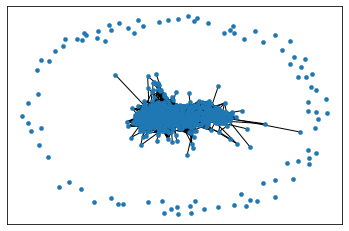

In [16]:
#Overview of Gene-Gene network from STRING database

G = nx.from_numpy_matrix(adj_mat)
nx.draw_networkx(G, node_size=20, with_labels=False, linewidths=0.2)